In [ ]:
# default_exp skymaps
from nbdev.showdoc import show_doc
from utilities.ipynb_docgen import *

%load_ext autoreload
%autoreload 2
! date

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Tue Aug  9 09:39:23 PDT 2022


# Sky maps
> Code for making maps of the sky, projecting HEALPix arrays

Plotting code 

* `HPmap` -- manage a HEALPix array
* `ait_plot` - make an  aitoff projection of the sky
* `SquareWCS` class for generating square images from all-sky healpix maps.



In [ ]:
#export
import os, sys
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import healpy


from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
#from utilities import healpix as hpx

from wtlike.config import *
from wtlike.data_man import DataView, get_week_map
from wtlike.sources import findsource

valid = Config().valid;

In [ ]:
# export
class AitoffFigure():

    """ Implement plot and text converting from (l,b) in degrees, or a SkyCoord.

    """    
    def __init__(self, fig):
        self.fig = fig
        self.ax = fig.axes[0]
        assert self.ax.__class__.__name__ == 'AitoffAxesSubplot', 'expect figure to have aitoff axes instance'
        
    def _trans(self, *args):
        if len(args)==2 and isinstance(args[0], SkyCoord):
            sc = args[0].galactic
            l, y, a = sc.l.rad, sc.b.rad, args[1] 
            x = -(l if l<=np.pi else l- 2*np.pi)
        elif len(args)==3:
            l, b, a = args
            x = -np.radians( (l if l<=180 else l-360 ))
            y = np.radians(b)
        else:
            raise Exception('Expect positional parameters l,b,a, or skycoord,a')
        return x,y, a
    
    def plot(self, *args, **kwargs):
        self.ax.plot(*self._trans(*args), **kwargs)
    
    def text(self, *args, **kwargs):
        self.ax.text(*self._trans(*args), **kwargs)
        
    def scatter(self, *args, **kwargs): # not checked yet
        self.ax.scatter(self._trans(*args), **kwags)

In [ ]:
#export

class SquareWCS(WCS):
    """
    Create and use a WCS object
    
    - center : a SkyCoord that will be the center
    - size   : width and height of the display
    - pixsize [0.1] : pixel size
    - frame [None] : The frame is taken from the center SkyCoord, unless specified here --  only accept "galactic" or "fk5"
    - proj ["ZEA"] : projection to use
    """
    
    def __init__(self, center, size, pixsize=0.1, frame=None, proj='ZEA'):
        """
        
        """
        assert isinstance(center, SkyCoord), 'Expect SkyCoord'
        
        frame = frame or center.frame.name
        if frame=='galactic':
            lon, lat = center.galactic.l.deg, center.galactic.b.deg
            lon_name,lat_name = 'GLON','GLAT'
            self.axis_labels='$l$', '$b$'
        elif frame=='fk5':
            lon,lat = center.fk5.ra.deg, center.fk5.dec.deg
            lon_name, lat_name = 'RA--', 'DEC-'
            self.axis_labels = 'RA', 'Dec'
        else:
            raise Exception(f'Expect frame to be "galactic" or "fk5", not {frame}')

        nx=ny=naxis = int(size/pixsize) | 1 # make odd so central pixel has source in middle
        self.center = center
        self.frame=frame
        self.galactic = frame=='galactic'
        super().__init__(
                         dict(
            NAXIS1=nx, CTYPE1=f'{lon_name}-{proj}', CUNIT1='deg', CRPIX1=nx//2+1, CRVAL1=lon, CDELT1=-pixsize,
            NAXIS2=ny, CTYPE2=f'{lat_name}-{proj}', CUNIT2='deg', CRPIX2=ny//2+1, CRVAL2=lat, CDELT2=pixsize, )
              )
        
    def _make_grid(self):
        # get coordinates of every pixel`
        nx, ny = self.array_shape
        pixlists = list(range(1,nx+1)),list(range(1,ny+1))
        cgrid = self.pixel_to_world(*np.meshgrid(*pixlists) ) 
        if not self.galactic:
            cgrid = cgrid.galactic
        lon, lat = (cgrid.l.deg, cgrid.b.deg) 
        return lon, lat
    
    def plot(self, hmap, log=False, cmap='jet', colorbar=True, size=6,
             unit='', vmin=None, vmax=None, cb_kw={}, 
             annotator=None, title=None, **kwargs):
        """
        - hmap -- a HEALPix map
    
        """
        
        import healpy as hp
        from matplotlib import colors
        
        wcs = self
        grid = self._make_grid();
        nside = hp.get_nside(hmap)

        # lon, lat = grid.l.deg, grid.b.deg
        ipix = hp.ang2pix(nside, *grid, lonlat=True)

        fig = plt.figure(figsize=(size,size))
        fig.add_subplot(111, projection=self)
        ax = fig.axes[0]
        
        if log:
            norm = colors.LogNorm(vmin=vmin,vmax=vmax)
            vmin=vmax=None
        else:
            norm = None
        ipix = hp.ang2pix(nside, *grid, lonlat=True)
        im = ax.imshow(hmap[ipix], cmap=cmap, origin='lower', norm=norm, vmin=vmin);
        
        nx, ny = wcs.array_shape
        ax.set(xlabel=self.axis_labels[0], xlim=(-0.5, nx-0.5),
               ylabel=self.axis_labels[1], ylim=(-0.5, ny-0.5),
              title= title)
        ax.grid();
        if colorbar:
            ticklabels = cb_kw.pop('ticklabels', None)
            cb_kw.update(label=unit,)
            cb = plt.colorbar(im, ax=ax, **cb_kw) 
            if ticklabels is not None: 
                cb.ax.set_yticklabels(ticklabels)
        if annotator is not None:
            annotator(ax, self.frame)
        return fig

In [ ]:
#export
class HPmap(object):
    """
    Manage HEALPix array
    """
    def __init__(self, 
            hpmap:'HEALPix array',
            name='', 
            cblabel=None,
            unit='',
            sigma:'smooth parameter'=None,
            nest=False):
        """create from a HEALPix array
        """
        self.name = name
        self.cblabel = cblabel if cblabel is not None else unit 
        self.unit = unit
        self.nside = healpy.get_nside(hpmap)
        # reorder as defaut RING if nest is set
        self.map = hpmap if not nest else healpy.reorder(hpmap, n2r=True)

        if sigma is not None:
            self.smooth(sigma)

    def __str__(self):
        return f'<{self.__class__.__name__}>, name "{self.name}" nside {self.nside} unit "{self.unit}"'
    def __repr__(self): return str(self)

    def __call__(self, sc:'SkyCoord') -> 'value[s]':
        """
        Return value of corresponding pixel(s)
        """
        sp = sc.spherical # avoid dependence on specific frame
        skyindex = healpy.ang2pix(self.nside, sp.lon.deg, sp.lat.deg, lonlat=True)
        return self.map[skyindex]

    def get_all_neighbors(self, pix):
        return healpy.get_all_neighbours(self.nside, pix)

    def smooth(self, sigma):
            self.map = healpy.smoothing(self.map, np.radians(sigma))

    @classmethod
    def from_FITS(cls, filename, *pars, **kwargs):
        with fits.open(filename) as hdus:
            header, data = hdus[1].header, hdus[1].data
        kw = dict(unit=header.get('TUNIT1', ''), name=header['TTYPE1'])
        kw.update(**kwargs)
        return cls(data.field(0), *pars, **kw)

    def ait_plot(self, **kwargs):
        """
        Invoke the function ait_plot to draw a representation
        
        """
        kw= dict(label=self.name, cblabel=self.unit,)
        kw.update(**kwargs)
        return ait_plot(self, **kw)
   
    def zea_plot(self, skycoord, size=20, pixsize=0.1, figsize=10, **kwargs):
        """
        """
        swcs = SquareWCS(skycoord, size, pixsize)
        return swcs.plot(self.map, size=figsize, **kwargs)

    def convolve(self, beam_window=None, sigma=0):
        """Convolve the map with a "beam", or PSF

        - beam_window: Legendre coefficients or None
        - sigma  Gaussian sigma in degrees

        return a HEALPix array
        """
        import healpy

        return healpy.alm2map(
            healpy.smoothalm( healpy.map2alm(self.map), 
                              sigma=np.radians(sigma), 
                              beam_window=beam_window
                            ),
            nside=self.nside
            )   

    def to_FITS(self,  filename=''):
        """return a HDUlist object with one skymap column
        
        - filename [''] write to the file if set
        """
        
        column = fits.Column(name=self.name, format='E', array=self.map, unit=self.unit)

        nside = self.nside
        cards = [fits.Card(*pars) for pars in [ 
            ('FIRSTPIX', 0,             'First pixel (0 based)'),
            ('LASTPIX',  12*nside**2, 'Last pixel (0 based)'),
            ('MAPTYPE',  'Fullsky' , ''  ),
            ('PIXTYPE',  'HEALPIX',      'Pixel algorithm',),
            ('ORDERING', 'RING',         'Ordering scheme'),
            ('NSIDE' ,   nside,    'Resolution Parameter'),
            ('ORDER',    int(np.log2(nside)),   'redundant'),
            ('INDXSCHM', 'IMPLICIT' ,''),
            ('OBJECT' ,  'FULLSKY', ''),
            ('COORDSYS', 'GAL', ''),
        ]]
        table = fits.BinTableHDU.from_columns([column],header=fits.Header(cards))
        table.name = 'SKYMAP'

        hdus = fits.HDUList([
                    fits.PrimaryHDU(header=None),
                    table,
                ])
        if filename:
            hdus.writeto(filename, overwrite=True)
            print(f'Wrote FITS file {filename}')
        return hdus
    

In [ ]:
# export

def ait_plot(mappable, 
        pars=[],
        label='',        
        title='',
        fig=None, ax=None, fignum=1, figsize=(12,6),
        pixelsize:'pixel size in deg'=1, 
        projection='aitoff',
        cmap='jet', 
        vmin=None, vmax=None,  vlim=None, pctlim=None,
        log=False,
        colorbar:bool=True,
        cblabel='',
        unit='',
        grid_color='grey',
        cb_kw={}, 
        axes_pos=111,
        axes_kw={},
        tick_labels=False,
        alpha:'apply to pcolormesh'=None,
        annotator:'callback'=None,
        ):
    
    """
    """
    from matplotlib import colors
    #  
    # code inspired by https://stackoverflow.com/questions/46063033/matplotlib-extent-with-mollweide-projection

    # make a mesh grid
    nx, ny = int(360/pixelsize), int(180/pixelsize)
    lon = np.linspace(180,-180, nx) # note reversed
    lat = np.linspace(-90., 90, ny)
    Lon,Lat = np.meshgrid(lon,lat)

    #  an arrary of values corresponding to the grid
    # dirs = SkyDir.from_galactic(Lon, Lat)
    dirs = SkyCoord(Lon, Lat, unit='deg')
    arr = mappable(dirs, *np.atleast_1d(pars))

    if ax:
        fig = ax.figure
        assert ax.__class__.__name__.startswith('AitoffAxes'), 'Require that be a AitoffAxes object'
    else:
        fig = plt.figure(figsize=figsize, num=fignum) if fig is None else fig
        # this needs to be more flexible
        ax = fig.add_subplot(axes_pos, projection=projection, **axes_kw)

    # reverse longitude sign here for display
    if pctlim is not None:
        vlim=np.percentile(mappable.map, np.array(pctlim)).round() #[40, 99.98])).round(), 
        
    if vlim is not None:
        vmin, vmax = vlim
        
    if log:
        norm = colors.LogNorm(vmin=vmin,vmax=vmax)
        vmin=vmax=None
    else:
        norm = None
    im = ax.pcolormesh(-np.radians(Lon), np.radians(Lat), arr,  shading='nearest',
        norm=norm, cmap=cmap,  vmin=vmin, vmax=vmax, alpha=alpha)
    
    if tick_labels:
        ff = lambda d: d if d>=0 else d+360
        ax.set_xticklabels([f'${ff(d):d}^\degree$' for d in np.linspace(150,-150, 11).astype(int)])
    else:
        ax.set(xticklabels=[], yticklabels=[], visible=True)
    
    if colorbar:
        ticklabels = cb_kw.pop('ticklabels', None)
        cb_kw.update(label=unit,)
        cb = plt.colorbar(im, ax=ax, **cb_kw) 
        if ticklabels is not None: 
            cb.ax.set_yticklabels(ticklabels)
    if grid_color: ax.grid(color=grid_color)  
    if label:
        ax.text( 0., 0.97, label, transform=ax.transAxes)
    if title:
        plt.suptitle(title, fontsize=12)
    if annotator:
        annotator(AitoffFigure(fig))

    return fig

## All sky AIT plot with full data set

Data collection: elapsed time: 81.9s (1.4 min)

Data set: from 2008-08-05 to 2022-08-10.

Plotted with nside=128, band index >= 8

Note that value limits, [   75. 10108.], correspond to specified percentiles (50, 99.98).

<figure style="margin-left: 5%" title="Figure 1">   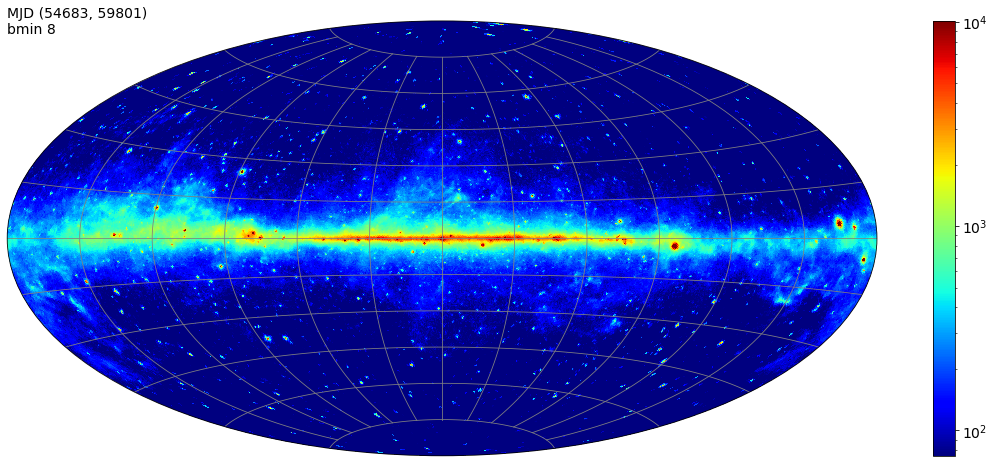 </figure>


In [ ]:
# collapse-hide
cntmap = None

@ipynb_doc
def all_sky_count_map(bmin=8, nside=128, pct=(50, 99.98)):
    """
    ## All sky AIT plot with full data set
    
    Data collection: {elapsed}
    
    Data set: from {start} to {stop}.
    
    Plotted with nside={nside}, band index >= {bmin}
    
    Note that value limits, {vlim}, correspond to specified percentiles {pct}.
    
    {fig}
    """
    global cntmap # save this for subsquent demos
    dvall = DataView()
    a, b = dvall.time_range
    start, stop = UTC(a)[:10], UTC(b)[:10]
    
    with Timer() as elapsed:
        cntmap = dvall.count_map(nside=nside, bmin=bmin)
   
    vlim = np.percentile(cntmap, pct).round()

    t = HPmap(cntmap, f'MJD {dvall.time_range}\nbmin {bmin}',
              unit=f'counts per nside={nside} pixel') 
    fig = t.ait_plot(log=True, tick_labels=False, pixelsize=0.2, figsize=(20,8.),
            vlim=vlim )
    
    return locals()

if valid: all_sky_count_map()

In [ ]:
# export
def plot_week(week=None, mjd=None, nside=32, **kwargs):
    """
    Make an AIT plot of the given week's photon data
    
    Combine all energies for now
    
    - week -- the week number from 9
    - mjd -- [None] If set, derive the week from it
    - nside [32] -- HEALPix nside to project data before plotting.
    - kwargs -- args for healpix.ait_plot
    
    """
    from utilities import healpix as hpx
    from wtlike.config import mission_week
    if mjd is not None: week=mission_week(mjd)

    pmap = get_week_map(week, nside=nside)

    kw = dict(log=True, tick_labels=False, vmin=5, vmax=1e3,
             )

    t = hpx.HPmap(pmap, f'week_{week:d}',unit=f'counts per nside={nside} pixel' #\n{utc}', 
                  **kwargs)#f'week_{week:d}\n{utc}', nest=True)
    t.ait_plot(**kw)
    return plt.gcf()

In [ ]:
show_doc(plot_week)

<h4 id="plot_week" class="doc_header"><code>plot_week</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>plot_week</code>(**`week`**=*`None`*, **`mjd`**=*`None`*, **`nside`**=*`32`*, **\*\*`kwargs`**)

Make an AIT plot of the given week's photon data

Combine all energies for now

- week -- the week number from 9
- mjd -- [None] If set, derive the week from it
- nside [32] -- HEALPix nside to project data before plotting.
- kwargs -- args for healpix.ait_plot

## Demonstrate a rotation of the HEALPix map

Uses the `Rotator` class of healpy

<figure style="margin-left: 5%" title="Figure 1">   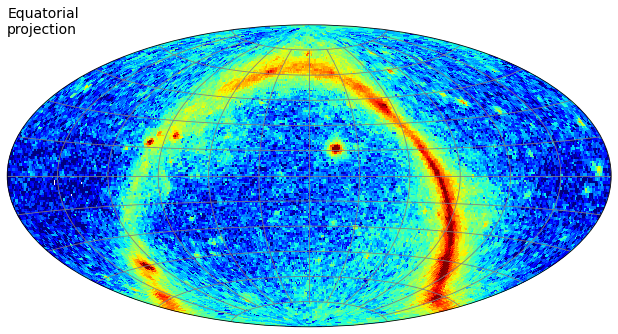 </figure>


In [ ]:
#collapse-hide
@ipynb_doc
def rotatedemo(week=79, nside=64):
    """
    ## Demonstrate a rotation of the HEALPix map
    
    Uses the `Rotator` class of healpy
    
    {fig}
    """
    from healpy.rotator import Rotator
    pmap = get_week_map(week, nside=nside)
    eqmap = Rotator(coord='GC').rotate_map_pixel(pmap)
    kw = dict(log=True, vmin=1, vmax=100, colorbar=False)
    HPmap(eqmap, f'Equatorial\nprojection').ait_plot(**kw);
    fig = figure(plt.gcf(), width=800)
    return locals()

if valid: rotatedemo()

In [ ]:
#export

class SquareWCS(WCS):
    """
    Create and use a WCS object
    
    - center : a SkyCoord that will be the center
    - size   : width and height of the display
    - pixsize [0.1] : pixel size
    - frame [None] : The frame is taken from the center SkyCoord, unless specified here --  only accept "galactic" or "fk5"
    - proj ["ZEA"] : projection to use
    """
    
    def __init__(self, center, size, pixsize=0.1, frame=None, proj='ZEA'):
        """
        
        """
        assert isinstance(center, SkyCoord), 'Expect SkyCoord'
        
        frame = frame or center.frame.name
        if frame=='galactic':
            lon, lat = center.galactic.l.deg, center.galactic.b.deg
            lon_name,lat_name = 'GLON','GLAT'
            self.axis_labels='$l$', '$b$'
        elif frame=='fk5':
            lon,lat = center.fk5.ra.deg, center.fk5.dec.deg
            lon_name, lat_name = 'RA--', 'DEC-'
            self.axis_labels = 'RA', 'Dec'
        else:
            raise Exception(f'Expect frame to be "galactic" or "fk5", not {frame}')

        nx=ny=naxis = int(size/pixsize) | 1 # make odd so central pixel has source in middle
        self.center = center
        self.frame=frame
        self.galactic = frame=='galactic'
        super().__init__(
                         dict(
            NAXIS1=nx, CTYPE1=f'{lon_name}-{proj}', CUNIT1='deg', CRPIX1=nx//2+1, CRVAL1=lon, CDELT1=-pixsize,
            NAXIS2=ny, CTYPE2=f'{lat_name}-{proj}', CUNIT2='deg', CRPIX2=ny//2+1, CRVAL2=lat, CDELT2=pixsize, )
              )
        
    def _make_grid(self):
        # get coordinates of every pixel`
        nx, ny = self.array_shape
        pixlists = list(range(1,nx+1)),list(range(1,ny+1))
        cgrid = self.pixel_to_world(*np.meshgrid(*pixlists) ) 
        if not self.galactic:
            cgrid = cgrid.galactic
        lon, lat = (cgrid.l.deg, cgrid.b.deg) 
        return lon, lat
    
    def plot(self, hmap, log=False, cmap='jet', colorbar=True, size=6,
             unit='', vmin=None, vmax=None, cb_kw={}, 
             annotator=None, title=None, **kwargs):
        """
        - hmap -- a HEALPix map
    
        """
        
        import healpy as hp
        from matplotlib import colors
        
        wcs = self
        grid = self._make_grid();
        nside = hp.get_nside(hmap)

        # lon, lat = grid.l.deg, grid.b.deg
        ipix = hp.ang2pix(nside, *grid, lonlat=True)

        fig = plt.figure(figsize=(size,size))
        fig.add_subplot(111, projection=self)
        ax = fig.axes[0]
        
        if log:
            norm = colors.LogNorm(vmin=vmin,vmax=vmax)
            vmin=vmax=None
        else:
            norm = None
        ipix = hp.ang2pix(nside, *grid, lonlat=True)
        im = ax.imshow(hmap[ipix], cmap=cmap, origin='lower', norm=norm, vmin=vmin);
        
        nx, ny = wcs.array_shape
        ax.set(xlabel=self.axis_labels[0], xlim=(-0.5, nx-0.5),
               ylabel=self.axis_labels[1], ylim=(-0.5, ny-0.5),
              title= title)
        ax.grid();
        if colorbar:
            ticklabels = cb_kw.pop('ticklabels', None)
            cb_kw.update(label=unit,)
            cb = plt.colorbar(im, ax=ax, **cb_kw) 
            if ticklabels is not None: 
                cb.ax.set_yticklabels(ticklabels)
        if annotator is not None:
            annotator(ax, self.frame)
        return fig

In [ ]:
show_doc(SquareWCS)
show_doc(SquareWCS.plot)

<h2 id="SquareWCS" class="doc_header"><code>class</code> <code>SquareWCS</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>SquareWCS</code>(**`center`**, **`size`**, **`pixsize`**=*`0.1`*, **`frame`**=*`None`*, **`proj`**=*`'ZEA'`*) :: `WCS`

Create and use a WCS object

- center : a SkyCoord that will be the center
- size   : width and height of the display
- pixsize [0.1] : pixel size
- frame [None] : The frame is taken from the center SkyCoord, unless specified here --  only accept "galactic" or "fk5"
- proj ["ZEA"] : projection to use

<h4 id="SquareWCS.plot" class="doc_header"><code>SquareWCS.plot</code><a href="__main__.py#L52" class="source_link" style="float:right">[source]</a></h4>

> <code>SquareWCS.plot</code>(**`hmap`**, **`log`**=*`False`*, **`cmap`**=*`'jet'`*, **`colorbar`**=*`True`*, **`size`**=*`6`*, **`unit`**=*`''`*, **`vmin`**=*`None`*, **`vmax`**=*`None`*, **`cb_kw`**=*`{}`*, **`annotator`**=*`None`*, **`title`**=*`None`*, **\*\*`kwargs`**)

- hmap -- a HEALPix map

## Demonstrate SquareWCS

This looks at a region of the all-sky count map generated above.

Start with  a $90^\circ$ plot in Galactic coordinates, centered on the source "Crab pulsar".

The `SquareWCS.plot` function is called with a callback specified by a kwarg `annotator`.
Here the `annotate`  function identifies Geminga and the Crab.
<figure style="margin-left: 5%" title="Figure 1">   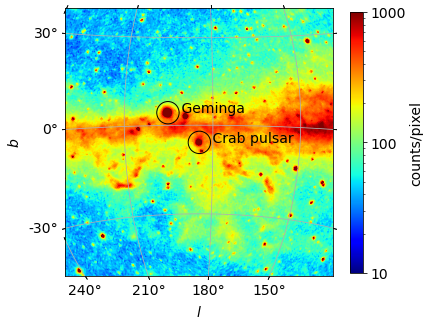 </figure>

Repeat, using the equatorial "fk5" frame for this one.
<figure style="margin-left: 5%" title="Figure 2">   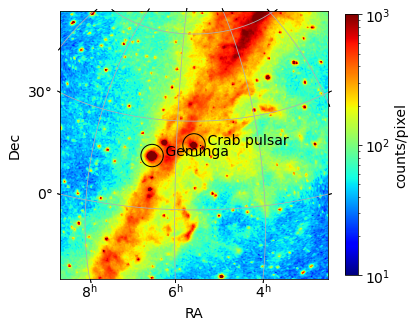 </figure>


In [ ]:
#collapse-hide

@ipynb_doc
def squaremap_demo(name, hpmap, size, vmin=10, vmax=1000):
    r"""
    ## Demonstrate SquareWCS
    
    This looks at a region of the all-sky count map generated above.
    
    Start with  a ${size}^\circ$ plot in Galactic coordinates, centered on the source "{name}".
    
    The `SquareWCS.plot` function is called with a callback specified by a kwarg `annotator`.
    Here the `annotate`  function identifies Geminga and the Crab.
    {fig1}
    
    Repeat, using the equatorial "fk5" frame for this one.
    {fig2}
    """

    sc = findsource(name, gal=True)

    swcs = SquareWCS(sc, size=90)

    def annotate(ax, frame):
        
        
        def source_lonlat(name, gal=True):            
            sky = findsource(name, gal=gal)
            if gal: return sky.galactic.l.deg, sky.galactic.b.deg
            return sky.ra.deg, sky.dec.deg
        
        tf =ax.get_transform(frame) # need the transformation from pixel to world
        for name in ['Geminga', 'Crab pulsar']:
            glb = source_lonlat(name, gal=frame=='galactic')
            ax.scatter(*glb , transform=tf, s=500, edgecolor='black', facecolor='none') 
            ax.text(*glb, '   '+name, color='black', transform=tf);

    cb_kw = dict(ticks = [0.1, 1, 10, 100, 1000],
                  ticklabels='0.1 1 10 100 1000'.split(), shrink=0.8)
    
    fig1 = swcs.plot(hpmap,  log=True, vmin=vmin, vmax=vmax, unit='counts/pixel',
              cb_kw=cb_kw, annotator = annotate)
    
    swcsc = SquareWCS(sc.fk5, size=90)

    fig2 = swcsc.plot(hpmap, log=True, vmin=vmin, vmax=vmax, unit='counts/pixel',
          cb_kw=cb_kw, annotator=annotate)
    return locals()

if valid: squaremap_demo('Crab pulsar', hpmap=cntmap, size=90, fignum=1)

In [ ]:
# export
def sun_dir(mjd):
    """The sun direction in galactic coordinates
    """
    from astropy.coordinates import get_sun, SkyCoord
    from astropy.time import Time
    s =  get_sun(Time(mjd, format='mjd'))
    return SkyCoord(s.ra, s.dec, frame='fk5').galactic

def draw_map(mapper, time_range, name='',  show_sun=False, 
               figsize=(9,4), utc_flag=True, fignum=1,
               **kwargs):
    """Draw a map.
    
    - mapper : a function of a (start,stop) time range that returns a HEALPix map
    - time_range : (start,stop) tuple
    - show_sun [False] : flag to show the sun path
    - utc_flage [True] : show progress bar in UTC, else MJD
    - ** kwargs : pass to the ait_plot function, e.g. vmin, vmax log, colorbar, title
    """
    from wtlike.data_man import DataView 
    from wtlike.config import first_data, MJD

    # set up the figure and an Axes object for Aitoff plot 
    fig = plt.figure(figsize=figsize, num=fignum) 
    ax1 = fig.add_axes([0.15,0.2,0.95,0.95], projection='aitoff')
    kw = dict(log=False, tick_labels=False, vmin=None, vmax=None, title='', colorbar=True)
    kw.update(**kwargs)
    
    # make and then plot the healpix map for the time range
    HPmap(mapper(time_range), name).ait_plot( ax=ax1, **kw)     
    
    if show_sun:
        sd = sun_dir(np.linspace(*time_range, num=30))
        l = sd.l.radian
        l[l>np.pi] -= 2*np.pi
        ax1.plot(-l, sd.b.radian, '.', color='orange')
    
    # set up a secod Axes object to show the time range
    ax2 = fig.add_axes([0.35, 0.1, 0.55, 0.11])
    kw2 = dict( xlim=(first_data, MJD('now')), ylim=(0,100),yticks=[], aspect=1 )
    ax2.axvspan(*time_range, color='orange')  
    if utc_flag:
        # even years if True else interpret as int
        cnt = 2 if type(utc_flag)==bool else utc_flag
        yrs = [str(yr) for yr in range(2008,2024, cnt)] #get this from kwarg maybe
        yrkw = dict( xticks=[MJD(yr) for yr in yrs], xticklabels=yrs,)#  xlabel='UTC',)
        kw2.update(**yrkw)
    ax2.set(**kw2)        
    return fig

### Livetime demo

Demonstrate the code to generate a 30-days map of livetime.
To generate an animation:
```
from wtlike.config import FermiMonth
p = Path('./livetime')
for k,t in  enumerate(FermiMonth()):

    filename = p/f'month_{k:03d}.png'
    fig =  make_ltmap(t, vmin=0, vmax=200, colorbar=False);
    fig.text(0.22,0.14, f'month {k+1}', fontsize=12)
    fig.savefig(filename, bbox_inches='tight')
    fig.clear()
```

The following command will make an animated gif
```
ffmpeg -i livetime/month_%03d.png -loop -framerate 1 monthly_livetime.gif
```
The framerate (frames/sec) does not seem to work
#### First and last months
The orange band is the path of the Sun during the 30 days.
<figure style="margin-left: 5%" title="Figure 1">   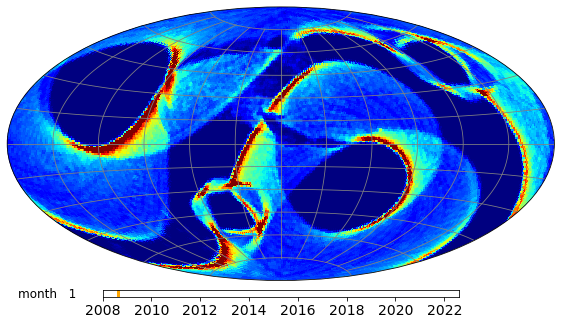 </figure>
<figure style="margin-left: 5%" title="Figure 2">   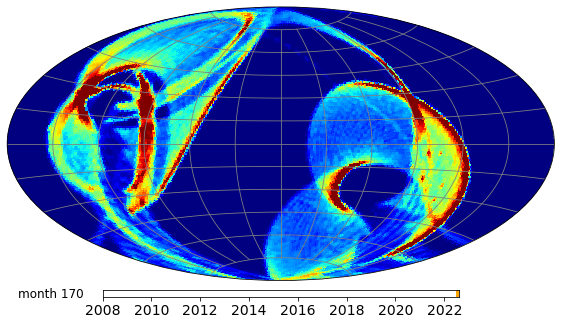 </figure>


In [ ]:
# collapse-hide
@ipynb_doc
def livetime_demo():
    """
    ### Livetime demo
    
    Demonstrate the code to generate a 30-days map of livetime.
    To generate an animation:
    ```
    from wtlike.config import FermiMonth
    p = Path('./livetime')
    for k,t in  enumerate(FermiMonth()):

        filename = p/f'month_{k:03d}.png'
        fig =  make_ltmap(t, vmin=0, vmax=200, colorbar=False);
        fig.text(0.22,0.14, f'month {k+1}', fontsize=12)
        fig.savefig(filename, bbox_inches='tight')
        fig.clear()
    ```
    
    The following command will make an animated gif
    ```
    ffmpeg -i livetime/month_%03d.png -loop -framerate 1 monthly_livetime.gif
    ```
    The framerate (frames/sec) does not seem to work
    #### First and last months
    The orange band is the path of the Sun during the 30 days.
    {fig1}
    {fig2}
    """
    from wtlike.config import FermiMonth
    fm = FermiInterval(30)

    def get_livetime(time_range):
        return DataView(time_range).livetime_map(sigma=2)
    
    def make_month(k):        
        fig =  draw_map(get_livetime, fm[k], fignum=k,
                      vmin=0, vmax=200, colorbar=False);
        month = k+1 if k>=0 else len(fm)+k+1
        fig.text(0.22,0.14, f'month {month:3}', fontsize=12)
        return fig
    fig1 = make_month(0)
    fig2 = make_month(-1)
    return locals()


if valid: livetime_demo()

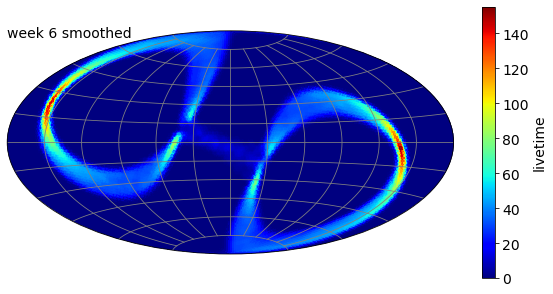

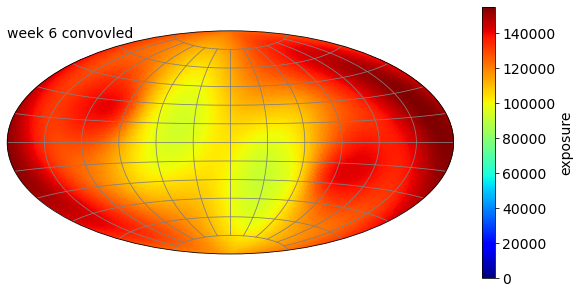

In [ ]:
# hide
if valid:
    def convolve(self, beam_window=None, sigma=0): #aeff_func):
        """Convolve the map with a "beam", or PSF

        - beam_window: Legendre coefficients or None. For Fermi aeff, use
                exposure.WeightedAeff(Config(), spectrum=None).beam_window() 
        - sigma  Gaussian sigma in degrees

        """
        import healpy

        return healpy.alm2map(
            healpy.smoothalm( healpy.map2alm(self.map), 
                              sigma=np.radians(sigma), 
                              beam_window=beam_window
                            ),
            nside=self.nside
            )  
    from wtlike.exposure import WeightedAeff
    fermiweek = FermiInterval(7)
    aeff_bw = WeightedAeff(Config(), spectrum=None).beam_window() 
    ltmap = HPmap(DataView(fermiweek[6]).livetime_map(), 'week 6')

    ait_kw = dict(colorbar=True,vmin=0, figsize=(10,5), tick_labels=False)
    HPmap(convolve(ltmap, None, 2), 'week 6 smoothed', ).ait_plot(fignum=1,unit='livetime', **ait_kw);
    HPmap(convolve(ltmap, aeff_bw), 'week 6 convovled',).ait_plot(fignum=2,unit='exposure', **ait_kw);

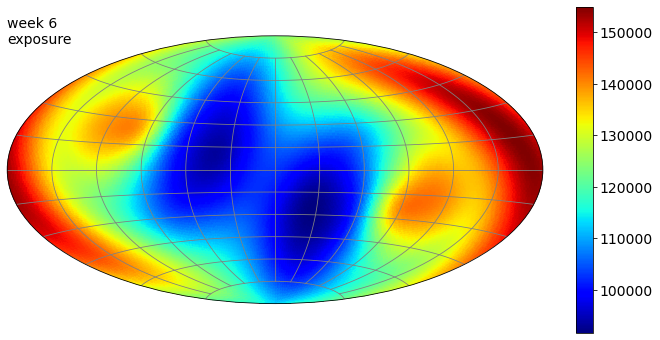

In [ ]:
#hide
if valid:
    aeff_bw = WeightedAeff(Config(), spectrum=None).beam_window() 
    emap = DataView(fermiweek[6]).exposure_map(aeff_bw)
    HPmap(emap, 'week 6\nexposure').ait_plot();

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 04_skymaps.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10-time_series.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_presentation.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Tue Aug  9 09:52:56 PDT 2022
